# B-spline interpolation task

Notebook showing a workflow example implementing the interpolation of time-series using B-splines

In [2]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import datetime

from sentinelhub import BBox, CRS

from eolearn.core import EOWorkflow, EOTask, FeatureType, Dependency, SaveToDisk, LoadFromDisk
from eolearn.io import S2L1CWCSInput, AddSen2CorClassificationFeature
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector
from eolearn.mask import AddValidDataMaskTask
from eolearn.features import BSplineInterpolation

Define ROI BBOX and time interval

In [3]:
roi_bbox = BBox(bbox=[-116.07124, 33.55431, -116.01335, 33.58277], crs=CRS.WGS84)
time_interval = ('2017-01-01', '2017-12-31')

In [4]:
class Plot(EOTask):
    def __init__(self, feature_type, feature_name, cmap=None):
        self.feature_type=feature_type
        self.feature_name=feature_name
        self.cmap=cmap
        
    def execute(self, eopatch):
        print('Plot | {} | {}'.format(self.feature_type, self.feature_name))
        print(' -> eopatch = {}'.format(type(eopatch)))
        
        array = {FeatureType.DATA:eopatch.data, 
                 FeatureType.DATA_TIMELESS:eopatch.data_timeless,
                 FeatureType.MASK:eopatch.mask,
                 FeatureType.MASK_TIMELESS:eopatch.mask_timeless}[self.feature_type][self.feature_name]
        
        print(eopatch.features)
        print(eopatch.meta_info)
        print(array.shape)
        
        plt.figure(figsize=(10,10))
        if len(array.shape) > 2:
            plt.imshow(array[-1],cmap=self.cmap)
        else:
            plt.imshow(array,cmap=self.cmap)
        
        return eopatch

### Compute cloud maps from new WMS request

In this workflow example, the cloud maps are computed from a new WMS request, as the input eopatch does not have the required data 

In [5]:
class ValidDataPredicate:
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

In [8]:
layer = 'BANDS-S2-L1C'

input_task = S2L1CWCSInput(layer=layer, 
                           resx='10m', resy='10m', 
                           maxcc=1, time_difference=datetime.timedelta(hours=2))

add_ndvi = S2L1CWCSInput(layer='NDVI')

cloud_classifier = get_s2_pixel_cloud_detector(all_bands=True)
add_clm = AddCloudMaskTask(cloud_classifier, 
                           'BANDS-S2-L1C', 
                           cm_size_y='60m', 
                           cm_size_x='60m', 
                           cmask_feature='CLM',
                           cprobs_feature='CLP')

add_valmask = AddValidDataMaskTask(predicate=ValidDataPredicate())

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [9]:
save = SaveToDisk('interpolation', overwrite=True, compress=True)

Run workflow and save the EOPatch to disk (for easier experimentation)

In [10]:
workflow = EOWorkflow(dependencies=[Dependency(transform=input_task, inputs=[]),
                                    Dependency(transform=add_ndvi, inputs=[input_task]),
                                    Dependency(transform=add_clm, inputs=[add_ndvi]),
                                    Dependency(transform=add_valmask, inputs=[add_clm]),
                                    Dependency(transform=save, inputs=[add_valmask])
                                    ])


In [11]:
result = workflow.execute({input_task: {'bbox': roi_bbox, 'time_interval': time_interval},
                           save:{'eopatch_folder':'patch'}})

INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connec

# Load from disk

In [12]:
load = LoadFromDisk('interpolation')

In [13]:
workflow_load = EOWorkflow(dependencies=[Dependency(transform=load, inputs=[]),
                                        ])

In [14]:
result = workflow_load.execute({load:{'eopatch_folder':'patch'}})

Plot results

In [15]:
patch_orig = result[load]

In [16]:
patch_orig.data['BANDS-S2-L1C'].shape

(48, 317, 537, 13)

In [17]:
patch_orig

EOPatch(
  data: {
    BANDS-S2-L1C: <class 'numpy.ndarray'>, shape=(48, 317, 537, 13), dtype=float32
    CLP: <class 'numpy.ndarray'>, shape=(48, 317, 537, 1), dtype=float32
    NDVI: <class 'numpy.ndarray'>, shape=(48, 317, 537, 1), dtype=float32
  }
  mask: {
    CLM: <class 'numpy.ndarray'>, shape=(48, 317, 537, 1), dtype=uint8
    IS_DATA: <class 'numpy.ndarray'>, shape=(48, 317, 537, 1), dtype=uint8
    VALID_DATA: <class 'numpy.ndarray'>, shape=(48, 317, 537, 1), dtype=bool
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(0, 7200)
    time_interval: <class 'tuple'>, length=2
  }
  bbox: BBox(((-116.07124, 33.55431), (-116.01335, 33.58277)), crs=EPSG:4326)
  timestamp: <class 'list'>, length=48
)

In [18]:
patch_orig.timestamp

[datetime.datetime(2017, 1, 1, 18, 27, 43),
 datetime.datetime(2017, 1, 11, 18, 27, 20),
 datetime.datetime(2017, 1, 31, 18, 25, 58),
 datetime.datetime(2017, 2, 10, 18, 31, 52),
 datetime.datetime(2017, 2, 20, 18, 32, 31),
 datetime.datetime(2017, 3, 2, 18, 33, 2),
 datetime.datetime(2017, 3, 12, 18, 29, 15),
 datetime.datetime(2017, 3, 22, 18, 33, 2),
 datetime.datetime(2017, 4, 1, 18, 30, 59),
 datetime.datetime(2017, 4, 11, 18, 33, 8),
 datetime.datetime(2017, 4, 21, 18, 29, 38),
 datetime.datetime(2017, 5, 1, 18, 33, 11),
 datetime.datetime(2017, 5, 11, 18, 29, 40),
 datetime.datetime(2017, 5, 21, 18, 33, 12),
 datetime.datetime(2017, 6, 10, 18, 33, 10),
 datetime.datetime(2017, 6, 20, 18, 28, 46),
 datetime.datetime(2017, 7, 5, 18, 33, 16),
 datetime.datetime(2017, 7, 10, 18, 29, 26),
 datetime.datetime(2017, 7, 15, 18, 32, 5),
 datetime.datetime(2017, 7, 20, 18, 33, 10),
 datetime.datetime(2017, 7, 25, 18, 34, 36),
 datetime.datetime(2017, 7, 30, 18, 29, 10),
 datetime.datetime(

In [19]:
def plot(patch, index):
    print(patch.timestamp[index])
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.imshow(bgr_to_rgb(patch.data['BANDS-S2-L1C'][index,:,:,1:4]*2.))
    plt.subplot(2,2,2)
    plt.imshow(patch.data['NDVI'][index].squeeze())
    plt.subplot(2,2,3)
    plt.imshow(patch.mask['VALID_DATA'][index].squeeze(),cmap=plt.cm.inferno,vmin=0,vmax=1)
    plt.subplot(2,2,4)
    plt.imshow(patch.data['CLP'][index,...,0],cmap=plt.cm.inferno,vmin=0,vmax=1)

In [20]:
mean_ndvi_all = np.mean(patch_orig.data['NDVI'],axis=(1,2))
std_ndvi_all  = np.std(patch_orig.data['NDVI'],axis=(1,2))

In [21]:
masked_ndvi_orig = ma.masked_array(patch_orig.data['NDVI'], mask = patch_orig.mask['VALID_DATA']==0)

In [22]:
mean_ndvi_valid = ma.mean(masked_ndvi_orig, axis=(1,2))
std_ndvi_valid  = ma.std(masked_ndvi_orig, axis=(1,2))

In [23]:
low_values = np.where(mean_ndvi_all<0.1)[0]

(0, 1)

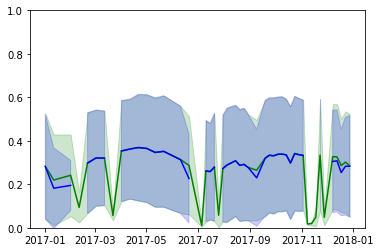

In [24]:
plt.plot(patch_orig.timestamp, mean_ndvi_all,color='g')
plt.fill_between(patch_orig.timestamp, mean_ndvi_all.squeeze()+std_ndvi_all.squeeze(),mean_ndvi_all.squeeze()-std_ndvi_all.squeeze(),alpha=0.2,color='g')
plt.plot(patch_orig.timestamp, mean_ndvi_valid,color='b')
plt.fill_between(patch_orig.timestamp, mean_ndvi_valid.squeeze()+std_ndvi_valid.squeeze(),mean_ndvi_valid.squeeze()-std_ndvi_valid.squeeze(),alpha=0.2,color='b')
plt.ylim(0,1)

2017-11-27 18:27:09


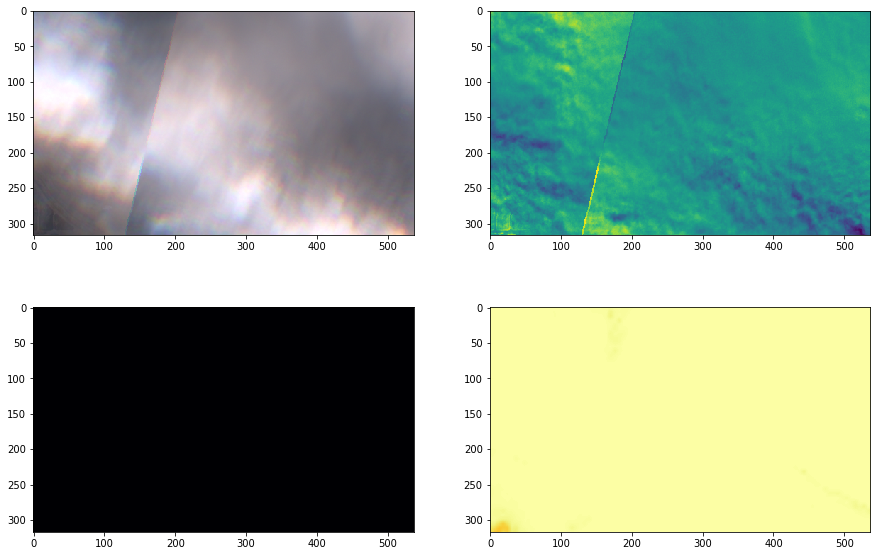

In [25]:
plot(patch_orig, low_values[-1])

2017-03-12 18:29:15


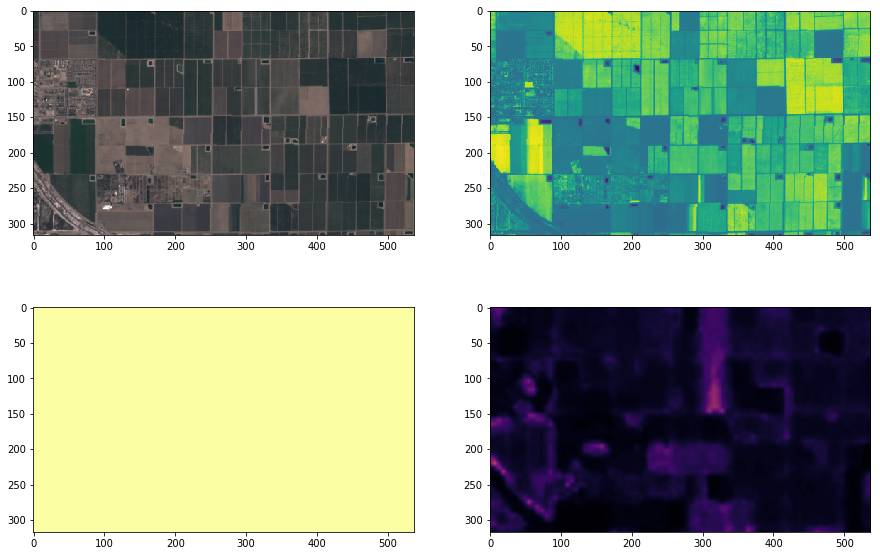

In [26]:
plot(patch_orig, 6)

In [27]:
mean_ndvi_feature1 = ma.mean(masked_ndvi_orig[:,0:66,120:200],axis=(1,2))
std_ndvi_feature1  = ma.std(masked_ndvi_orig[:,0:66,120:200],axis=(1,2))
mean_ndvi_feature2 = ma.average(masked_ndvi_orig[:,70:150,340:360],axis=(1,2))
std_ndvi_feature2  = ma.std(masked_ndvi_orig[:,70:150,340:360],axis=(1,2))
mean_ndvi_feature3 = ma.average(masked_ndvi_orig[:,74:140,0:80],axis=(1,2))
std_ndvi_feature3  = ma.std(masked_ndvi_orig[:,74:140,0:80],axis=(1,2))

(0, 1)

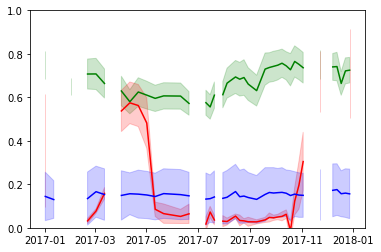

In [28]:
plt.plot(patch_orig.timestamp, mean_ndvi_feature1,color='g')
plt.fill_between(patch_orig.timestamp, mean_ndvi_feature1.squeeze()+std_ndvi_feature1.squeeze(),mean_ndvi_feature1.squeeze()-std_ndvi_feature1.squeeze(),alpha=0.2,color='g')
plt.plot(patch_orig.timestamp, mean_ndvi_feature2,color='r')
plt.fill_between(patch_orig.timestamp, mean_ndvi_feature2.squeeze()+std_ndvi_feature2.squeeze(),mean_ndvi_feature2.squeeze()-std_ndvi_feature2.squeeze(),alpha=0.2,color='r')
plt.plot(patch_orig.timestamp, mean_ndvi_feature3,color='b')
plt.fill_between(patch_orig.timestamp, mean_ndvi_feature3.squeeze()+std_ndvi_feature3.squeeze(),mean_ndvi_feature3.squeeze()-std_ndvi_feature3.squeeze(),alpha=0.2,color='b')
plt.ylim(0,1)
# plt.savefig('orig_3areas.png')

# The Interpolation/Smoothing Task

In [77]:
interp = BSplineInterpolation((FeatureType.DATA, 'NDVI'), mask_feature=(FeatureType.MASK, 'VALID_DATA'), 
                              resample_range=('2017-02-01', '2017-11-30', 7),
                              spline_degree=3)

In [78]:
workflow_interp = EOWorkflow(dependencies=[Dependency(transform=load, inputs=[]),
                                           Dependency(transform=interp, inputs=[load])
                                          ])

In [79]:
result_interp = workflow_interp.execute({load:{'eopatch_folder':'patch'}})

In [80]:
result_interp

WorkflowResults(
  Dependency(BSplineInterpolation): EOPatch(
  data: {
    NDVI: <class 'numpy.ndarray'>, shape=(44, 317, 537, 1), dtype=float32
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((-116.07124, 33.55431), (-116.01335, 33.58277)), crs=EPSG:4326)
  timestamp: <class 'list'>, length=44
)
)

In [81]:
np.count_nonzero(patch_orig.data['NDVI']-patch.data['NDVI'])/patch.data['NDVI'].size

0.21856636256650355

In [82]:
patch = result_interp[interp]

In [84]:
ndvis = patch.data['NDVI']

In [85]:
mean_spline_ndvi_feature1 = np.mean(ndvis[:,0:66,120:200],axis=(1,2))
std_spline_ndvi_feature1  = np.std(ndvis[:,0:66,120:200],axis=(1,2))
mean_spline_ndvi_feature2 = np.mean(ndvis[:,70:150,340:360],axis=(1,2))
std_spline_ndvi_feature2  = np.std(ndvis[:,70:150,340:360],axis=(1,2))
mean_spline_ndvi_feature3 = np.mean(ndvis[:,74:140,0:80],axis=(1,2))
std_spline_ndvi_feature3  = np.std(ndvis[:,74:140,0:80],axis=(1,2))

(0, 1)

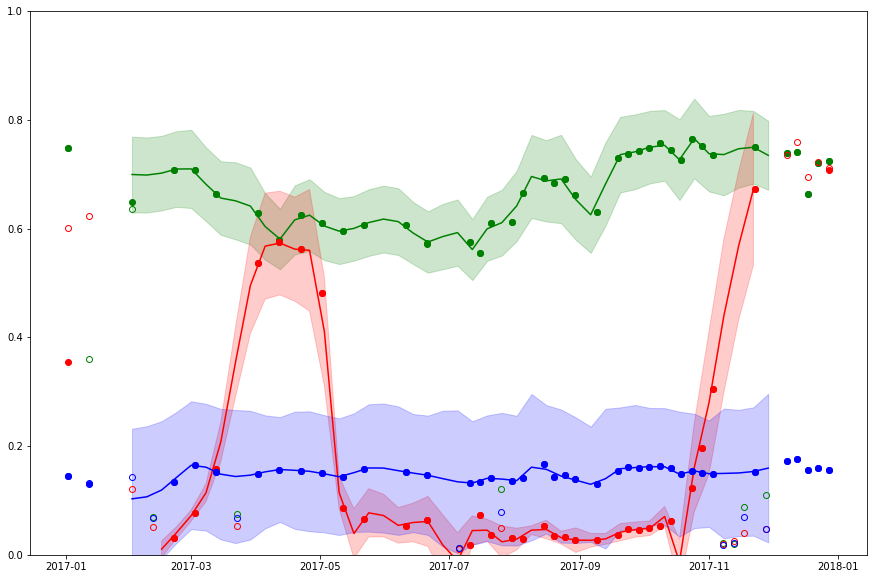

In [86]:
plt.figure(figsize=(15,10))
plt.plot(patch_orig.timestamp, np.mean(patch_orig.data['NDVI'][:,0:66,120:200],axis=(1,2)),'o', markeredgewidth=1, markeredgecolor='g', markerfacecolor='None',)
plt.plot(patch_orig.timestamp, mean_ndvi_feature1,'o',color='g')
plt.plot(patch.timestamp, mean_spline_ndvi_feature1,color='g')
plt.fill_between(patch.timestamp, mean_spline_ndvi_feature1.squeeze()+std_spline_ndvi_feature1.squeeze(),mean_spline_ndvi_feature1.squeeze()-std_spline_ndvi_feature1.squeeze(),alpha=0.2,color='g')
plt.plot(patch_orig.timestamp, np.mean(patch_orig.data['NDVI'][:,70:150,340:360],axis=(1,2)),'o', markeredgewidth=1, markeredgecolor='r', markerfacecolor='None',)
plt.plot(patch_orig.timestamp, mean_ndvi_feature2,'o',color='r')
plt.plot(patch.timestamp, mean_spline_ndvi_feature2,color='r')
plt.fill_between(patch.timestamp, mean_spline_ndvi_feature2.squeeze()+std_spline_ndvi_feature2.squeeze(),mean_spline_ndvi_feature2.squeeze()-std_spline_ndvi_feature2.squeeze(),alpha=0.2,color='r')
plt.plot(patch_orig.timestamp, np.mean(patch_orig.data['NDVI'][:,74:140,0:80],axis=(1,2)),'o', markeredgewidth=1, markeredgecolor='b', markerfacecolor='None',)
plt.plot(patch_orig.timestamp, mean_ndvi_feature3,'o',color='b')
plt.plot(patch.timestamp, mean_spline_ndvi_feature3,color='b')
plt.fill_between(patch.timestamp, mean_spline_ndvi_feature3.squeeze()+std_spline_ndvi_feature3.squeeze(),mean_spline_ndvi_feature3.squeeze()-std_spline_ndvi_feature3.squeeze(),alpha=0.2,color='b')

plt.ylim(0,1)
# plt.savefig('final_plot.png')

(0, 1)

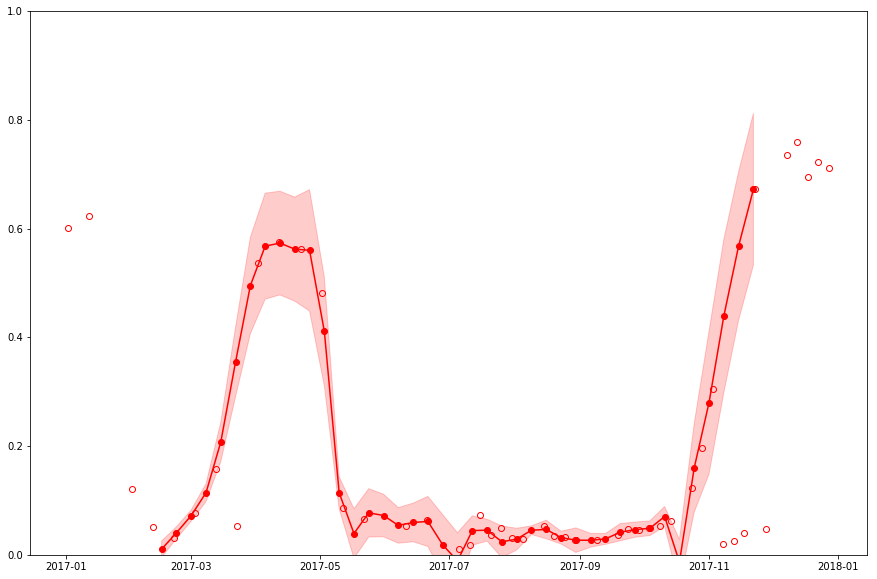

In [91]:
plt.figure(figsize=(15,10))
plt.plot(patch_orig.timestamp, np.mean(patch_orig.data['NDVI'][:,70:150,340:360],axis=(1,2)),'o', markeredgewidth=1, markeredgecolor='r', markerfacecolor='None',)
plt.plot(patch.timestamp, mean_spline_ndvi_feature2,'o-',color='r')
plt.fill_between(patch.timestamp, mean_spline_ndvi_feature2.squeeze()+std_spline_ndvi_feature2.squeeze(),mean_spline_ndvi_feature2.squeeze()-std_spline_ndvi_feature2.squeeze(),alpha=0.2,color='r')
plt.ylim(0,1)
#plt.savefig('red_plot.png')

2017-01-01 18:27:43


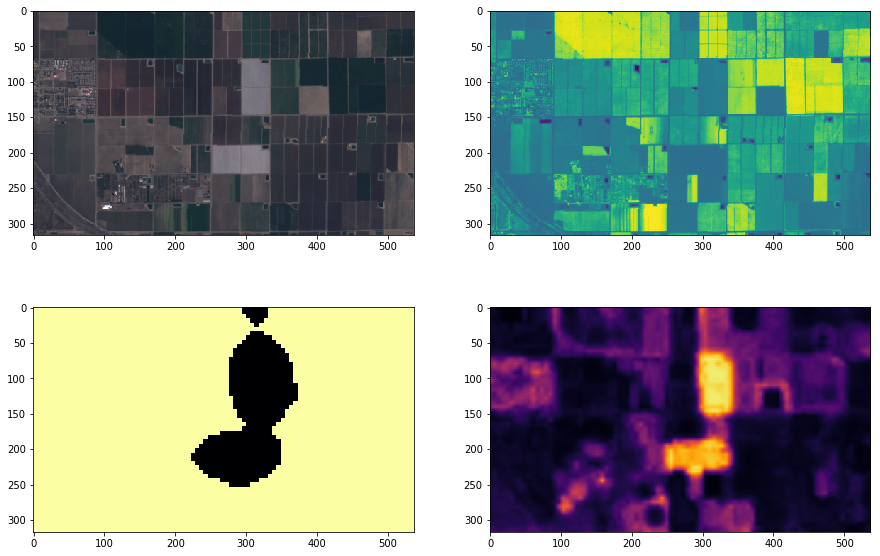

In [69]:
plot(patch_orig,0)

2017-12-22 18:31:28


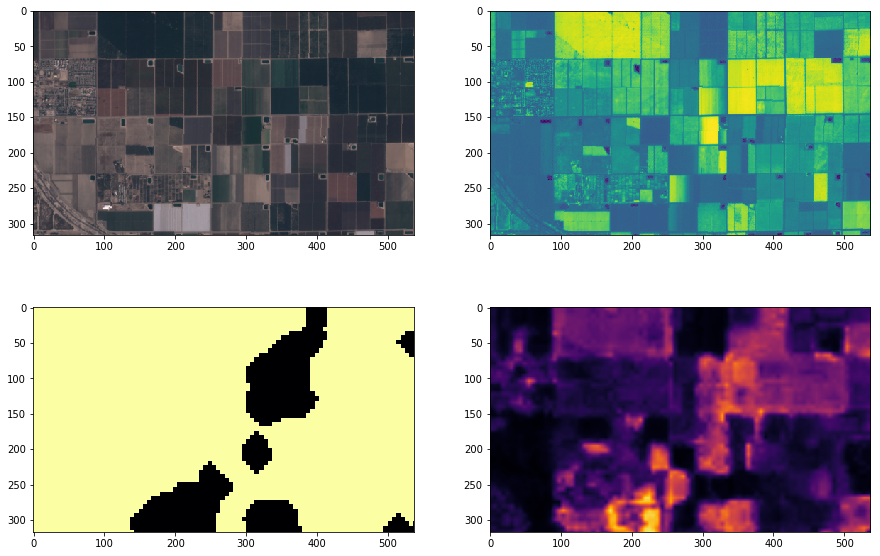

In [70]:
plot(patch_orig,-2)